In [54]:
%matplotlib inline
import numpy as np
import os
import math
import openmc
from openmc.model import borated_water
os.environ["PATH"] = "/storage/work/vai5027/.conda/envs/openmc-env1/bin:" + os.environ["PATH"]

os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/home/vai5027/work/NUCE403/endfb-viii/cross_sections.xml"
## Defining materials


# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration).
# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3
fuel = openmc.Material(name='uo2_gad')
fuel.add_nuclide('U235', 0.02)
fuel.add_nuclide('U238', 0.98)
#fuel.add_element('Gd', 0.000075)
fuel.add_nuclide('O16', 2)
fuel.set_density('g/cm3', 11.5)

cladding = openmc.Material(name='zircaloy4')
cladding.add_element('Zr',0.98)
cladding.add_element('Sn',0.015)
cladding.add_element('Fe',0.002)
cladding.add_element('Cr',0.001)
cladding.add_element('O',0.001)
cladding.add_element('Hf', 0.001)
cladding.set_density('g/cm3', 6.34)

water = openmc.Material(name='h2o')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

boron_ppm_concentration = 1000
temperature_k = 600.0
pressure_mpa = 15 # MPa

water_material = openmc.model.borated_water(
    boron_ppm=boron_ppm_concentration,
    temperature=temperature_k,
    pressure=pressure_mpa
)

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4)
ctrl_rod.set_density('g/cm3', 2.5)

rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation
rpv.add_element('Fe', 0.7)
rpv.add_element('Cr', 0.2)
rpv.add_element('Ni', 0.08)
rpv.add_element('Mn', 0.01)
rpv.add_element('C', 0.01)
rpv.set_density('g/cm3', 7.6)

mats = openmc.Materials([fuel, cladding, water_material, ctrl_rod, rpv])
mats.export_to_xml()



## Defining geometry


# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods
# Specify boundary conditions only to the exterior surfaces
# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)

H_core = 225
R_core = 70
cyl_uo2 = openmc.ZCylinder(r=0.6)
cyl_clad = openmc.ZCylinder(r=0.62)
cyl_ctrl = openmc.ZCylinder(r=0.62)
cyl_no_ctrl = openmc.ZCylinder(r=0.62)
cyl_rpv_i = openmc.ZCylinder(r=R_core-5)
cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

# regions
uo2_region = -cyl_uo2 & -z_max & +z_min
clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min
water_region = +cyl_clad & -z_max & +z_min
ctrl_region = -cyl_ctrl & -z_max & +z_min
no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min
water_ctrl_region = +cyl_ctrl & -z_max & +z_min
water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min
rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min
water_rod_region = -cyl_ctrl & -z_max & +z_min

# cells
uo2_cell = openmc.Cell(name='fuel')
uo2_cell.region = uo2_region
uo2_cell.fill = fuel

clad_cell = openmc.Cell(name='cladding')
clad_cell.region = clad_region
clad_cell.fill = cladding

ctrl_cell = openmc.Cell(name='ctrl_rod')
ctrl_cell.region = ctrl_region
ctrl_cell.fill = ctrl_rod

no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')
no_ctrl_cell.region = no_ctrl_region
no_ctrl_cell.fill = water_material

water_cell = openmc.Cell(name='water_material')
water_cell.region = water_region
water_cell.fill = water_material

water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_ctrl.region = water_ctrl_region
water_cell_ctrl.fill = water_material

water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_no_ctrl.region = water_no_ctrl_region
water_cell_no_ctrl.fill = water_material

rpv_cell = openmc.Cell(name='vessel')
rpv_cell.region = rpv_region
rpv_cell.fill = rpv

water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')
water_rod_cell.region = water_rod_region
water_rod_cell.fill = water_material

# universes, the outer universe i see it as a safety net so that everything is covered

fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water_material)])
no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])

lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly
lat.center = (0.0, 0.0)
lat.pitch = (2.5,)           # i picked this number just to make it fit, no calculations.
# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring
lat.outer = outer_universe

outer_ring = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled
lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure


# this defines the fuel assembly cell so that it can be stacked
a = 2.75 * lat.pitch[0]  # formula
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)

assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged

core_lat = openmc.HexLattice()
core_lat.center = (0.,0.)
core_lat.pitch = (np.sqrt(3)*a,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous
core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter
core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
#ring_6 = [assembly_univ] * 30
# ring_7 = [assembly_univ] * 36
core_lat.universes = [ring_5, ring_4, ring_3, ring_2, ring_1]

# only the "water" of the core, no pressure vessel
whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)

geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here
geom.export_to_xml()



In [55]:
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.run_mode = 'eigenvalue'
settings.export_to_xml()

In [56]:
 # Depletion Cell
import openmc.deplete
fuel.volume = np.pi * (cyl_uo2.r**2) * H_core * 1638
chain = openmc.deplete.Chain.from_xml("./chain_simple.xml")
model = openmc.Model(geometry=geom, settings=settings)
operator = openmc.deplete.CoupledOperator(model, chain)
power = 20e6 # W
time_steps = [0.1,0.2,0.4,0.8,1.6,2.5,5,5,5,5,5,5,10,10,10,10,20,10,10,40,10,10,80,100,100,100,100,100,200,300,400]
cecm = openmc.deplete.CECMIntegrator(operator, time_steps, power, timestep_units='d') # also better options available
cecm.integrate()




                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/B11.h5
 Reading H1 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/H1.h5
 Reading H2 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/H2.h5
 Reading C12 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/C12.h5
 Reading C13 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/C13.h5
 Reading Mn55 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Mn55.h5
 Reading Ni58 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni58.h5
 Reading Ni60 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni60.h5
 Reading Ni61 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni61.h5
 Reading Ni62 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni62.h5
 Reading Ni64 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni64.h5
 Reading c_H_in_H2O from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/c_H_in_H2O.h5
 Minimum neutron data tempera

          1200K
          2500K


 Reading Gd157 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Gd157.h5
 Reading Cs137 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Cs137.h5
 Reading Ba137 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ba137.h5
 Reading Gd156 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Gd156.h5
 Reading U234 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/U234.h5
 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.97718
        2/1    0.90341
        3/1    0.91195
        4/1    0.88313
        5/1    0.83056
        6/1    0.88544
        7/1    0.87896
        8/1    0.87468
        9/1    0.84763
       10/1    0.88209
       11/1    0.84644
       12/1    0.87678    0.86161 +/- 0.01517
       13/1    0.88571    0.

       41/1    0.92578    0.87706 +/- 0.00742
       42/1    0.92579    0.87858 +/- 0.00734
       43/1    0.83368    0.87722 +/- 0.00725
       44/1    0.79879    0.87492 +/- 0.00740
       45/1    0.84922    0.87418 +/- 0.00722
       46/1    0.84478    0.87336 +/- 0.00706
       47/1    0.80177    0.87143 +/- 0.00714
       48/1    0.90703    0.87237 +/- 0.00701
       49/1    0.90848    0.87329 +/- 0.00689
       50/1    0.90472    0.87408 +/- 0.00676
       51/1    0.80909    0.87249 +/- 0.00678
       52/1    0.82149    0.87128 +/- 0.00673
       53/1    0.86922    0.87123 +/- 0.00657
       54/1    0.85290    0.87081 +/- 0.00643
       55/1    0.90271    0.87152 +/- 0.00633
       56/1    0.78670    0.86968 +/- 0.00646
       57/1    0.86249    0.86953 +/- 0.00632
       58/1    0.88049    0.86975 +/- 0.00619
       59/1    0.82669    0.86888 +/- 0.00613
       60/1    0.90012    0.86950 +/- 0.00604
       61/1    0.86957    0.86950 +/- 0.00592
       62/1    0.82633    0.86867 

       93/1    0.88255    0.87241 +/- 0.00426
       94/1    0.90060    0.87274 +/- 0.00422
       95/1    0.89812    0.87304 +/- 0.00418
       96/1    0.86034    0.87290 +/- 0.00413
       97/1    0.83966    0.87251 +/- 0.00410
       98/1    0.85915    0.87236 +/- 0.00406
       99/1    0.93634    0.87308 +/- 0.00408
      100/1    0.90525    0.87344 +/- 0.00405
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9484e+00 seconds
   Time in transport only          = 5.8304e+00 seconds
   Time in inactive batches        = 4.7036e-01 seconds
   Time in active batches          = 5.4780e+00 seconds
   Time synchronizing fission bank = 6.0003e-03 seconds
     Sampling source sites         = 4.6386e-03 seconds
     SEND/RECV source sites        = 1.1484e-03 seconds
   Tim

       13/1    0.83755    0.91826 +/- 0.04969
       14/1    0.83348    0.89706 +/- 0.04104
       15/1    0.88126    0.89390 +/- 0.03194
       16/1    0.86959    0.88985 +/- 0.02639
       17/1    0.87009    0.88703 +/- 0.02249
       18/1    0.84012    0.88116 +/- 0.02034
       19/1    0.88015    0.88105 +/- 0.01794
       20/1    0.87911    0.88086 +/- 0.01604
       21/1    0.80499    0.87396 +/- 0.01607
       22/1    0.80764    0.86843 +/- 0.01567
       23/1    0.88648    0.86982 +/- 0.01448
       24/1    0.87177    0.86996 +/- 0.01341
       25/1    0.86566    0.86967 +/- 0.01249
       26/1    0.83693    0.86763 +/- 0.01186
       27/1    0.90567    0.86987 +/- 0.01136
       28/1    0.93810    0.87366 +/- 0.01136
       29/1    0.87467    0.87371 +/- 0.01075
       30/1    0.85978    0.87301 +/- 0.01022
       31/1    0.88574    0.87362 +/- 0.00974
       32/1    0.82900    0.87159 +/- 0.00951
       33/1    0.83610    0.87005 +/- 0.00921
       34/1    0.90414    0.87147 

       65/1    0.89332    0.86386 +/- 0.00533
       66/1    0.84889    0.86359 +/- 0.00524
       67/1    0.78818    0.86227 +/- 0.00532
       68/1    0.89088    0.86276 +/- 0.00525
       69/1    0.89127    0.86324 +/- 0.00518
       70/1    0.85852    0.86317 +/- 0.00510
       71/1    0.84440    0.86286 +/- 0.00502
       72/1    0.84354    0.86255 +/- 0.00495
       73/1    0.88802    0.86295 +/- 0.00489
       74/1    0.78912    0.86180 +/- 0.00495
       75/1    0.82925    0.86130 +/- 0.00490
       76/1    0.84129    0.86099 +/- 0.00483
       77/1    0.87829    0.86125 +/- 0.00476
       78/1    0.90622    0.86191 +/- 0.00474
       79/1    0.85643    0.86183 +/- 0.00467
       80/1    0.85967    0.86180 +/- 0.00460
       81/1    0.90629    0.86243 +/- 0.00458
       82/1    0.86899    0.86252 +/- 0.00452
       83/1    0.81990    0.86194 +/- 0.00450
       84/1    0.90236    0.86248 +/- 0.00447
       85/1    0.86448    0.86251 +/- 0.00441
       86/1    0.87064    0.86262 

 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.89557
        2/1    0.97997
        3/1    0.96142
        4/1    0.90126
        5/1    0.88410
        6/1    0.87072
        7/1    0.85882
        8/1    0.91137
        9/1    0.88780
       10/1    0.88295
       11/1    0.88119
       12/1    0.85775    0.86947 +/- 0.01172
       13/1    0.94128    0.89341 +/- 0.02488
       14/1    0.85433    0.88364 +/- 0.02012
       15/1    0.80393    0.86769 +/- 0.02229
       16/1    0.84734    0.86430 +/- 0.01852
       17/1    0.80382    0.85566 +/- 0.01788
       18/1    0.80754    0.84965 +/- 0.01661
       19/1    0.86040    0.85084 +/- 0.01470
       20/1    0.90251    0.85601 +/- 0.01412
       21/1    0.91862    0.86170 +/- 0.01399
       22/1    0.88178    0.863

       53/1    0.84886    0.85944 +/- 0.00476
       54/1    0.90519    0.86048 +/- 0.00476
       55/1    0.88556    0.86104 +/- 0.00469
       56/1    0.85056    0.86081 +/- 0.00459
       57/1    0.84906    0.86056 +/- 0.00450
       58/1    0.86318    0.86061 +/- 0.00440
       59/1    0.87795    0.86097 +/- 0.00433
       60/1    0.80823    0.85991 +/- 0.00437
       61/1    0.82862    0.85930 +/- 0.00433
       62/1    0.90468    0.86017 +/- 0.00433
       63/1    0.79879    0.85901 +/- 0.00440
       64/1    0.87528    0.85932 +/- 0.00433
       65/1    0.82177    0.85863 +/- 0.00431
       66/1    0.84098    0.85832 +/- 0.00424
       67/1    0.82723    0.85777 +/- 0.00420
       68/1    0.79263    0.85665 +/- 0.00428
       69/1    0.88562    0.85714 +/- 0.00423
       70/1    0.93698    0.85847 +/- 0.00437
       71/1    0.82610    0.85794 +/- 0.00433
       72/1    0.81915    0.85731 +/- 0.00431
       73/1    0.82442    0.85679 +/- 0.00427
       74/1    0.94865    0.85823 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9082e+00 seconds
   Time in transport only          = 5.7876e+00 seconds
   Time in inactive batches        = 4.6100e-01 seconds
   Time in active batches          = 5.4472e+00 seconds
   Time synchronizing fission bank = 5.9514e-03 seconds
     Sampling source sites         = 4.5542e-03 seconds
     SEND/RECV source sites        = 1.1379e-03 seconds
   Time accumulating tallies       = 3.9557e-04 seconds
   Time writing statepoints        = 1.0037e-01 seconds
 Total time for finalization       = 9.8149e-03 seconds
 Total time elapsed                = 5.9707e+00 seconds
 Calculation Rate (inactive)       = 21691.7 particles/second
 Calculation Rate (active)         = 16522.4 particles/second

 ============================>     RESULTS     <====================

       21/1    0.86938    0.88371 +/- 0.00814
       22/1    0.83319    0.87950 +/- 0.00854
       23/1    0.81274    0.87437 +/- 0.00938
       24/1    0.89024    0.87550 +/- 0.00876
       25/1    0.83070    0.87251 +/- 0.00869
       26/1    0.89953    0.87420 +/- 0.00830
       27/1    0.87374    0.87417 +/- 0.00780
       28/1    0.81348    0.87080 +/- 0.00809
       29/1    0.89688    0.87218 +/- 0.00777
       30/1    0.86478    0.87181 +/- 0.00738
       31/1    0.83443    0.87003 +/- 0.00724
       32/1    0.87696    0.87034 +/- 0.00691
       33/1    0.84997    0.86946 +/- 0.00666
       34/1    0.85958    0.86904 +/- 0.00639
       35/1    0.84242    0.86798 +/- 0.00622
       36/1    0.87466    0.86824 +/- 0.00599
       37/1    0.83793    0.86711 +/- 0.00587
       38/1    0.84985    0.86650 +/- 0.00569
       39/1    0.85207    0.86600 +/- 0.00551
       40/1    0.85232    0.86554 +/- 0.00534
       41/1    0.88465    0.86616 +/- 0.00521
       42/1    0.74894    0.86250 

       73/1    0.91471    0.86614 +/- 0.00466
       74/1    0.88154    0.86638 +/- 0.00460
       75/1    0.90528    0.86698 +/- 0.00456
       76/1    0.82915    0.86641 +/- 0.00453
       77/1    0.83736    0.86597 +/- 0.00448
       78/1    0.79338    0.86491 +/- 0.00454
       79/1    0.86109    0.86485 +/- 0.00448
       80/1    0.82285    0.86425 +/- 0.00445
       81/1    0.87660    0.86442 +/- 0.00440
       82/1    0.88979    0.86478 +/- 0.00435
       83/1    0.86505    0.86478 +/- 0.00429
       84/1    0.91006    0.86539 +/- 0.00427
       85/1    0.86117    0.86534 +/- 0.00422
       86/1    0.87654    0.86548 +/- 0.00416
       87/1    0.83739    0.86512 +/- 0.00413
       88/1    0.75366    0.86369 +/- 0.00432
       89/1    0.89766    0.86412 +/- 0.00428
       90/1    0.89462    0.86450 +/- 0.00425
       91/1    0.82638    0.86403 +/- 0.00422
       92/1    0.88989    0.86435 +/- 0.00418
       93/1    0.86389    0.86434 +/- 0.00413
       94/1    0.86857    0.86439 

[openmc.deplete] t=915840.0 s, dt=432000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.97025
        2/1    1.02834
        3/1    0.87712
        4/1    0.93289
        5/1    0.93051
        6/1    0.86994
        7/1    0.87112
        8/1    0.89953
        9/1    0.87929
       10/1    0.80519
       11/1    0.83227
       12/1    0.92656    0.87941 +/- 0.04714
       13/1    0.89205    0.88362 +/- 0.02754
       14/1    0.89527    0.88654 +/- 0.01969
       15/1    0.93606    0.89644 +/- 0.01819
       16/1    0.89471    0.89615 +/- 0.01485
       17/1    0.88330    0.89432 +/- 0.01269
       18/1    0.91706    0.89716 +/- 0.01135
       19/1    0.80401    0.88681 +/- 0.01440
       20/1    0.83238    0.88137 +/- 0.01398
       21/1  

       49/1    0.91787    0.85825 +/- 0.00554
       50/1    0.90935    0.85953 +/- 0.00555
       51/1    0.85076    0.85932 +/- 0.00541
       52/1    0.83899    0.85883 +/- 0.00531
       53/1    0.92385    0.86035 +/- 0.00540
       54/1    0.90519    0.86137 +/- 0.00537
       55/1    0.91768    0.86262 +/- 0.00540
       56/1    0.80781    0.86143 +/- 0.00541
       57/1    0.86396    0.86148 +/- 0.00530
       58/1    0.86124    0.86147 +/- 0.00518
       59/1    0.85102    0.86126 +/- 0.00508
       60/1    0.89626    0.86196 +/- 0.00503
       61/1    0.92166    0.86313 +/- 0.00507
       62/1    0.89306    0.86371 +/- 0.00500
       63/1    0.90340    0.86446 +/- 0.00496
       64/1    0.96241    0.86627 +/- 0.00520
       65/1    0.86237    0.86620 +/- 0.00510
       66/1    0.85143    0.86594 +/- 0.00502
       67/1    0.87733    0.86614 +/- 0.00493
       68/1    0.80203    0.86503 +/- 0.00497
       69/1    0.85194    0.86481 +/- 0.00489
       70/1    0.83561    0.86432 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.8940e+00 seconds
   Time in transport only          = 5.7611e+00 seconds
   Time in inactive batches        = 4.6608e-01 seconds
   Time in active batches          = 5.4279e+00 seconds
   Time synchronizing fission bank = 5.9194e-03 seconds
     Sampling source sites         = 4.5588e-03 seconds
     SEND/RECV source sites        = 1.1550e-03 seconds
   Time accumulating tallies       = 3.7676e-04 seconds
   Time writing statepoints        = 1.1298e-01 seconds
 Total time for finalization       = 7.2005e-03 seconds
 Total time elapsed                = 5.9546e+00 seconds
 Calculation Rate (inactive)       = 21455.6 particles/second
 Calculation Rate (active)         = 16581 particles/second

 ============================>     RESULTS     <======================

       21/1    0.90711    0.85822 +/- 0.00997
       22/1    0.92037    0.86340 +/- 0.01047
       23/1    0.85660    0.86288 +/- 0.00965
       24/1    0.81786    0.85966 +/- 0.00949
       25/1    0.86753    0.86019 +/- 0.00885
       26/1    0.84362    0.85915 +/- 0.00835
       27/1    0.87362    0.86000 +/- 0.00789
       28/1    0.90004    0.86223 +/- 0.00776
       29/1    0.81307    0.85964 +/- 0.00778
       30/1    0.85316    0.85932 +/- 0.00739
       31/1    0.83202    0.85802 +/- 0.00715
       32/1    0.86050    0.85813 +/- 0.00682
       33/1    0.83010    0.85691 +/- 0.00663
       34/1    0.85180    0.85670 +/- 0.00635
       35/1    0.85211    0.85651 +/- 0.00609
       36/1    0.79176    0.85402 +/- 0.00636
       37/1    0.83108    0.85317 +/- 0.00618
       38/1    0.86991    0.85377 +/- 0.00598
       39/1    0.81887    0.85257 +/- 0.00590
       40/1    0.91609    0.85469 +/- 0.00608
       41/1    0.82462    0.85372 +/- 0.00596
       42/1    0.80173    0.85209 

       73/1    0.88148    0.86848 +/- 0.00435
       74/1    0.85828    0.86832 +/- 0.00428
       75/1    0.85650    0.86814 +/- 0.00422
       76/1    0.88958    0.86847 +/- 0.00417
       77/1    0.91693    0.86919 +/- 0.00417
       78/1    0.85522    0.86898 +/- 0.00411
       79/1    0.85400    0.86877 +/- 0.00406
       80/1    0.91014    0.86936 +/- 0.00404
       81/1    0.95503    0.87056 +/- 0.00416
       82/1    0.88213    0.87073 +/- 0.00411
       83/1    0.84775    0.87041 +/- 0.00406
       84/1    0.92203    0.87111 +/- 0.00407
       85/1    0.88447    0.87129 +/- 0.00402
       86/1    0.82059    0.87062 +/- 0.00402
       87/1    0.89650    0.87096 +/- 0.00398
       88/1    0.84170    0.87058 +/- 0.00395
       89/1    0.82164    0.86996 +/- 0.00395
       90/1    0.88831    0.87019 +/- 0.00390
       91/1    0.85703    0.87003 +/- 0.00386
       92/1    0.84913    0.86977 +/- 0.00382
       93/1    0.83117    0.86931 +/- 0.00380
       94/1    0.90429    0.86972 

 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.95859
        2/1    0.97621
        3/1    0.87191
        4/1    0.88834
        5/1    0.85428
        6/1    0.90243
        7/1    0.80052
        8/1    0.80962
        9/1    0.83465
       10/1    0.88652
       11/1    0.87115
       12/1    0.89430    0.88272 +/- 0.01157
       13/1    0.83601    0.86715 +/- 0.01694
       14/1    0.84893    0.86260 +/- 0.01282
       15/1    0.86796    0.86367 +/- 0.00999
       16/1    0.81190    0.85504 +/- 0.01187
       17/1    0.86363    0.85627 +/- 0.01011
       18/1    0.82225    0.85202 +/- 0.00973
       19/1    0.90494    0.85790 +/- 0.01040
       20/1    0.87186    0.85929 +/- 0.00941
       21/1    0.87190    0.86044 +/- 0.00859
       22/1    0.86565    0.860

       53/1    0.87368    0.85570 +/- 0.00654
       54/1    0.83942    0.85533 +/- 0.00640
       55/1    0.86072    0.85545 +/- 0.00625
       56/1    0.87398    0.85585 +/- 0.00613
       57/1    0.89699    0.85673 +/- 0.00606
       58/1    0.90067    0.85764 +/- 0.00600
       59/1    0.88264    0.85815 +/- 0.00590
       60/1    0.84174    0.85783 +/- 0.00579
       61/1    0.83473    0.85737 +/- 0.00570
       62/1    0.91635    0.85851 +/- 0.00570
       63/1    0.85749    0.85849 +/- 0.00559
       64/1    0.83432    0.85804 +/- 0.00550
       65/1    0.83996    0.85771 +/- 0.00541
       66/1    0.83110    0.85724 +/- 0.00534
       67/1    0.87210    0.85750 +/- 0.00525
       68/1    0.83741    0.85715 +/- 0.00517
       69/1    0.87132    0.85739 +/- 0.00509
       70/1    0.83101    0.85695 +/- 0.00502
       71/1    0.88183    0.85736 +/- 0.00495
       72/1    0.86209    0.85744 +/- 0.00487
       73/1    0.83886    0.85714 +/- 0.00481
       74/1    0.85881    0.85717 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9380e+00 seconds
   Time in transport only          = 5.7809e+00 seconds
   Time in inactive batches        = 4.7538e-01 seconds
   Time in active batches          = 5.4626e+00 seconds
   Time synchronizing fission bank = 6.0561e-03 seconds
     Sampling source sites         = 4.6498e-03 seconds
     SEND/RECV source sites        = 1.1753e-03 seconds
   Time accumulating tallies       = 3.9285e-04 seconds
   Time writing statepoints        = 1.3727e-01 seconds
 Total time for finalization       = 4.6538e-03 seconds
 Total time elapsed                = 5.9955e+00 seconds
 Calculation Rate (inactive)       = 21035.6 particles/second
 Calculation Rate (active)         = 16475.6 particles/second

 ============================>     RESULTS     <====================

       21/1    0.85147    0.86597 +/- 0.01097
       22/1    0.91996    0.87047 +/- 0.01098
       23/1    0.83539    0.86777 +/- 0.01045
       24/1    0.85725    0.86702 +/- 0.00971
       25/1    0.87611    0.86763 +/- 0.00906
       26/1    0.83597    0.86565 +/- 0.00870
       27/1    0.83329    0.86374 +/- 0.00839
       28/1    0.85164    0.86307 +/- 0.00794
       29/1    0.86856    0.86336 +/- 0.00751
       30/1    0.92599    0.86649 +/- 0.00779
       31/1    0.86298    0.86633 +/- 0.00741
       32/1    0.89058    0.86743 +/- 0.00715
       33/1    0.85908    0.86706 +/- 0.00684
       34/1    0.88161    0.86767 +/- 0.00658
       35/1    0.83943    0.86654 +/- 0.00641
       36/1    0.89353    0.86758 +/- 0.00624
       37/1    0.82770    0.86610 +/- 0.00619
       38/1    0.85027    0.86554 +/- 0.00599
       39/1    0.83956    0.86464 +/- 0.00585
       40/1    0.86080    0.86451 +/- 0.00565
       41/1    0.83300    0.86350 +/- 0.00556
       42/1    0.90309    0.86473 

       73/1    0.82588    0.85805 +/- 0.00383
       74/1    0.82536    0.85754 +/- 0.00381
       75/1    0.87090    0.85774 +/- 0.00375
       76/1    0.82824    0.85729 +/- 0.00372
       77/1    0.88613    0.85772 +/- 0.00369
       78/1    0.91115    0.85851 +/- 0.00372
       79/1    0.90043    0.85912 +/- 0.00372
       80/1    0.83420    0.85876 +/- 0.00368
       81/1    0.82983    0.85835 +/- 0.00365
       82/1    0.84189    0.85813 +/- 0.00361
       83/1    0.84521    0.85795 +/- 0.00356
       84/1    0.85691    0.85793 +/- 0.00352
       85/1    0.83123    0.85758 +/- 0.00349
       86/1    0.98029    0.85919 +/- 0.00380
       87/1    0.86070    0.85921 +/- 0.00375
       88/1    0.82293    0.85875 +/- 0.00373
       89/1    0.83594    0.85846 +/- 0.00369
       90/1    0.89668    0.85894 +/- 0.00368
       91/1    0.84023    0.85871 +/- 0.00364
       92/1    0.82854    0.85834 +/- 0.00362
       93/1    0.85182    0.85826 +/- 0.00357
       94/1    0.88291    0.85855 

 ============================>     RESULTS     <============================

 k-effective (Collision)     = 0.85925 +/- 0.00365
 k-effective (Track-length)  = 0.85575 +/- 0.00378
 k-effective (Absorption)    = 0.85997 +/- 0.00315
 Combined k-effective        = 0.85797 +/- 0.00271
 Leakage Fraction            = 0.01026 +/- 0.00032

[openmc.deplete] t=4803840.0 s, dt=864000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.92161
        2/1    0.90983
        3/1    0.90298
        4/1    0.90246
        5/1    0.90777
        6/1    0.93478
        7/1    0.84216
        8/1    0.84557
        9/1    0.82469
       10/1    0.86978
       11/1    0.78107
       12/1    0.81675    0.79891 +/- 0.01784
       13/1    0.86891    0.82224 +/- 0.02551


       41/1    0.87062    0.84625 +/- 0.00558
       42/1    0.89754    0.84785 +/- 0.00563
       43/1    0.83838    0.84756 +/- 0.00547
       44/1    0.84782    0.84757 +/- 0.00530
       45/1    0.86061    0.84794 +/- 0.00516
       46/1    0.86457    0.84840 +/- 0.00504
       47/1    0.87359    0.84909 +/- 0.00495
       48/1    0.79652    0.84770 +/- 0.00501
       49/1    0.90685    0.84922 +/- 0.00511
       50/1    0.84913    0.84922 +/- 0.00498
       51/1    0.86720    0.84966 +/- 0.00488
       52/1    0.87894    0.85035 +/- 0.00481
       53/1    0.84226    0.85016 +/- 0.00470
       54/1    0.81107    0.84928 +/- 0.00468
       55/1    0.87576    0.84986 +/- 0.00461
       56/1    0.88249    0.85057 +/- 0.00457
       57/1    0.86943    0.85097 +/- 0.00449
       58/1    0.86828    0.85134 +/- 0.00441
       59/1    0.86105    0.85153 +/- 0.00432
       60/1    0.86016    0.85171 +/- 0.00424
       61/1    0.87403    0.85214 +/- 0.00417
       62/1    0.89867    0.85304 

       93/1    0.84103    0.85867 +/- 0.00339
       94/1    0.84995    0.85857 +/- 0.00335
       95/1    0.86627    0.85866 +/- 0.00331
       96/1    0.83731    0.85841 +/- 0.00328
       97/1    0.88362    0.85870 +/- 0.00326
       98/1    0.83706    0.85845 +/- 0.00323
       99/1    0.88177    0.85871 +/- 0.00320
      100/1    0.87694    0.85892 +/- 0.00317
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9550e+00 seconds
   Time in transport only          = 5.8211e+00 seconds
   Time in inactive batches        = 5.0528e-01 seconds
   Time in active batches          = 5.4498e+00 seconds
   Time synchronizing fission bank = 5.9769e-03 seconds
     Sampling source sites         = 4.6155e-03 seconds
     SEND/RECV source sites        = 1.1535e-03 seconds
   Tim

       13/1    0.84124    0.85540 +/- 0.02083
       14/1    0.82041    0.84665 +/- 0.01713
       15/1    0.86332    0.84998 +/- 0.01368
       16/1    0.84965    0.84993 +/- 0.01117
       17/1    0.80774    0.84390 +/- 0.01120
       18/1    0.88401    0.84891 +/- 0.01092
       19/1    0.83947    0.84786 +/- 0.00969
       20/1    0.89504    0.85258 +/- 0.00987
       21/1    0.79974    0.84778 +/- 0.01013
       22/1    0.90690    0.85270 +/- 0.01048
       23/1    0.89406    0.85589 +/- 0.01015
       24/1    0.84627    0.85520 +/- 0.00942
       25/1    0.87815    0.85673 +/- 0.00891
       26/1    0.87885    0.85811 +/- 0.00844
       27/1    0.91322    0.86135 +/- 0.00857
       28/1    0.84572    0.86048 +/- 0.00813
       29/1    0.84647    0.85975 +/- 0.00772
       30/1    0.87041    0.86028 +/- 0.00734
       31/1    0.83420    0.85904 +/- 0.00710
       32/1    0.83457    0.85793 +/- 0.00686
       33/1    0.80658    0.85569 +/- 0.00692
       34/1    0.86239    0.85597 

       65/1    0.90295    0.84884 +/- 0.00442
       66/1    0.79921    0.84796 +/- 0.00443
       67/1    0.86210    0.84821 +/- 0.00436
       68/1    0.85835    0.84838 +/- 0.00428
       69/1    0.81571    0.84783 +/- 0.00425
       70/1    0.89261    0.84857 +/- 0.00424
       71/1    0.91201    0.84961 +/- 0.00430
       72/1    0.80583    0.84891 +/- 0.00429
       73/1    0.80257    0.84817 +/- 0.00428
       74/1    0.85794    0.84832 +/- 0.00422
       75/1    0.83867    0.84818 +/- 0.00416
       76/1    0.86721    0.84846 +/- 0.00410
       77/1    0.85391    0.84855 +/- 0.00404
       78/1    0.84231    0.84845 +/- 0.00398
       79/1    0.81475    0.84797 +/- 0.00396
       80/1    0.82794    0.84768 +/- 0.00391
       81/1    0.84301    0.84761 +/- 0.00385
       82/1    0.86047    0.84779 +/- 0.00380
       83/1    0.87995    0.84823 +/- 0.00378
       84/1    0.90938    0.84906 +/- 0.00382
       85/1    0.84404    0.84899 +/- 0.00377
       86/1    0.88337    0.84944 

 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.90744
        2/1    1.03803
        3/1    0.89533
        4/1    0.93889
        5/1    0.86470
        6/1    0.84200
        7/1    0.86228
        8/1    0.83828
        9/1    0.89024
       10/1    0.86453
       11/1    0.88357
       12/1    0.83720    0.86039 +/- 0.02319
       13/1    0.88494    0.86857 +/- 0.01569
       14/1    0.89901    0.87618 +/- 0.01345
       15/1    0.83111    0.86717 +/- 0.01378
       16/1    0.88354    0.86990 +/- 0.01158
       17/1    0.88762    0.87243 +/- 0.01011
       18/1    0.84960    0.86957 +/- 0.00921
       19/1    0.81818    0.86386 +/- 0.00993
       20/1    0.85858    0.86333 +/- 0.00889
       21/1    0.82769    0.86009 +/- 0.00867
       22/1    0.80490    0.855

       50/1    0.84903    0.84725 +/- 0.00485
       51/1    0.84708    0.84724 +/- 0.00473
       52/1    0.83503    0.84695 +/- 0.00463
       53/1    0.85982    0.84725 +/- 0.00453
       54/1    0.87425    0.84786 +/- 0.00446
       55/1    0.84861    0.84788 +/- 0.00436
       56/1    0.85423    0.84802 +/- 0.00427
       57/1    0.87386    0.84857 +/- 0.00422
       58/1    0.83695    0.84833 +/- 0.00413
       59/1    0.86518    0.84867 +/- 0.00406
       60/1    0.85573    0.84881 +/- 0.00398
       61/1    0.80555    0.84796 +/- 0.00400
       62/1    0.91477    0.84925 +/- 0.00412
       63/1    0.85765    0.84941 +/- 0.00405
       64/1    0.92185    0.85075 +/- 0.00419
       65/1    0.84204    0.85059 +/- 0.00412
       66/1    0.84792    0.85054 +/- 0.00404
       67/1    0.88280    0.85111 +/- 0.00401
       68/1    0.82520    0.85066 +/- 0.00397
       69/1    0.81638    0.85008 +/- 0.00394
       70/1    0.78938    0.84907 +/- 0.00401
       71/1    0.86160    0.84927 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9385e+00 seconds
   Time in transport only          = 5.8240e+00 seconds
   Time in inactive batches        = 4.6920e-01 seconds
   Time in active batches          = 5.4693e+00 seconds
   Time synchronizing fission bank = 6.0243e-03 seconds
     Sampling source sites         = 4.6702e-03 seconds
     SEND/RECV source sites        = 1.1364e-03 seconds
   Time accumulating tallies       = 5.9073e-04 seconds
   Time writing statepoints        = 9.4509e-02 seconds
 Total time for finalization       = 1.3396e-02 seconds
 Total time elapsed                = 6.0076e+00 seconds
 Calculation Rate (inactive)       = 21312.9 particles/second
 Calculation Rate (active)         = 16455.5 particles/second

 ============================>     RESULTS     <====================

       21/1    0.78996    0.83536 +/- 0.01023
       22/1    0.81739    0.83386 +/- 0.00945
       23/1    0.87358    0.83692 +/- 0.00922
       24/1    0.90333    0.84166 +/- 0.00976
       25/1    0.86311    0.84309 +/- 0.00920
       26/1    0.82978    0.84226 +/- 0.00865
       27/1    0.83834    0.84203 +/- 0.00813
       28/1    0.79879    0.83963 +/- 0.00803
       29/1    0.82287    0.83874 +/- 0.00765
       30/1    0.79587    0.83660 +/- 0.00756
       31/1    0.86361    0.83789 +/- 0.00731
       32/1    0.88620    0.84008 +/- 0.00731
       33/1    0.83778    0.83998 +/- 0.00698
       34/1    0.79709    0.83820 +/- 0.00692
       35/1    0.85421    0.83884 +/- 0.00667
       36/1    0.82830    0.83843 +/- 0.00642
       37/1    0.78995    0.83664 +/- 0.00643
       38/1    0.88252    0.83827 +/- 0.00641
       39/1    0.88591    0.83992 +/- 0.00640
       40/1    0.81313    0.83902 +/- 0.00625
       41/1    0.87096    0.84005 +/- 0.00613
       42/1    0.86004    0.84068 

       73/1    0.86379    0.84614 +/- 0.00428
       74/1    0.86070    0.84636 +/- 0.00422
       75/1    0.83335    0.84616 +/- 0.00416
       76/1    0.84015    0.84607 +/- 0.00410
       77/1    0.90524    0.84696 +/- 0.00413
       78/1    0.85597    0.84709 +/- 0.00407
       79/1    0.81939    0.84669 +/- 0.00403
       80/1    0.79445    0.84594 +/- 0.00404
       81/1    0.88091    0.84643 +/- 0.00402
       82/1    0.75179    0.84512 +/- 0.00417
       83/1    0.78613    0.84431 +/- 0.00419
       84/1    0.87379    0.84471 +/- 0.00416
       85/1    0.87128    0.84506 +/- 0.00411
       86/1    0.79871    0.84445 +/- 0.00411
       87/1    0.84513    0.84446 +/- 0.00405
       88/1    0.83424    0.84433 +/- 0.00400
       89/1    0.84000    0.84428 +/- 0.00395
       90/1    0.88871    0.84483 +/- 0.00394
       91/1    0.82896    0.84464 +/- 0.00390
       92/1    0.84148    0.84460 +/- 0.00385
       93/1    0.87682    0.84499 +/- 0.00382
       94/1    0.87606    0.84536 

[openmc.deplete] t=14307840.0 s, dt=864000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.95472
        2/1    0.94955
        3/1    0.90008
        4/1    0.90245
        5/1    0.87232
        6/1    0.85369
        7/1    0.76360
        8/1    0.81418
        9/1    0.90151
       10/1    0.86774
       11/1    0.84627
       12/1    0.89140    0.86883 +/- 0.02256
       13/1    0.86713    0.86827 +/- 0.01304
       14/1    0.85770    0.86562 +/- 0.00959
       15/1    0.92750    0.87800 +/- 0.01443
       16/1    0.85241    0.87373 +/- 0.01253
       17/1    0.85611    0.87122 +/- 0.01089
       18/1    0.79947    0.86225 +/- 0.01301
       19/1    0.81885    0.85743 +/- 0.01245
       20/1    0.84921    0.85661 +/- 0.01116
       21/1

       48/1    0.78444    0.84286 +/- 0.00650
       49/1    0.83271    0.84260 +/- 0.00634
       50/1    0.87426    0.84339 +/- 0.00623
       51/1    0.86112    0.84383 +/- 0.00609
       52/1    0.88131    0.84472 +/- 0.00601
       53/1    0.85572    0.84498 +/- 0.00587
       54/1    0.80237    0.84401 +/- 0.00582
       55/1    0.81677    0.84340 +/- 0.00572
       56/1    0.86443    0.84386 +/- 0.00561
       57/1    0.79498    0.84282 +/- 0.00559
       58/1    0.83413    0.84264 +/- 0.00547
       59/1    0.86841    0.84316 +/- 0.00539
       60/1    0.83650    0.84303 +/- 0.00528
       61/1    0.83994    0.84297 +/- 0.00518
       62/1    0.86625    0.84342 +/- 0.00510
       63/1    0.82837    0.84313 +/- 0.00501
       64/1    0.87822    0.84378 +/- 0.00496
       65/1    0.83601    0.84364 +/- 0.00487
       66/1    0.83329    0.84346 +/- 0.00478
       67/1    0.79361    0.84258 +/- 0.00478
       68/1    0.74910    0.84097 +/- 0.00496
       69/1    0.87433    0.84154 

       97/1    0.86485    0.84136 +/- 0.00395
       98/1    0.86546    0.84163 +/- 0.00391
       99/1    0.81450    0.84133 +/- 0.00388
      100/1    0.84357    0.84135 +/- 0.00384
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.9681e+00 seconds
   Time in transport only          = 5.8393e+00 seconds
   Time in inactive batches        = 4.6970e-01 seconds
   Time in active batches          = 5.4984e+00 seconds
   Time synchronizing fission bank = 6.2104e-03 seconds
     Sampling source sites         = 4.7689e-03 seconds
     SEND/RECV source sites        = 1.1940e-03 seconds
   Time accumulating tallies       = 6.1413e-04 seconds
   Time writing statepoints        = 1.0838e-01 seconds
 Total time for finalization       = 7.9223e-03 seconds
 Total time elapsed   

       17/1    0.79633    0.83849 +/- 0.01184
       18/1    0.81247    0.83523 +/- 0.01076
       19/1    0.84352    0.83616 +/- 0.00953
       20/1    0.88717    0.84126 +/- 0.00994
       21/1    0.82605    0.83987 +/- 0.00909
       22/1    0.79751    0.83634 +/- 0.00902
       23/1    0.85751    0.83797 +/- 0.00846
       24/1    0.80450    0.83558 +/- 0.00819
       25/1    0.82962    0.83518 +/- 0.00763
       26/1    0.81176    0.83372 +/- 0.00729
       27/1    0.85480    0.83496 +/- 0.00696
       28/1    0.84530    0.83553 +/- 0.00658
       29/1    0.80892    0.83413 +/- 0.00638
       30/1    0.94218    0.83954 +/- 0.00811
       31/1    0.76735    0.83610 +/- 0.00845
       32/1    0.87318    0.83778 +/- 0.00823
       33/1    0.84300    0.83801 +/- 0.00787
       34/1    0.80802    0.83676 +/- 0.00764
       35/1    0.85074    0.83732 +/- 0.00735
       36/1    0.85713    0.83808 +/- 0.00710
       37/1    0.84305    0.83827 +/- 0.00683
       38/1    0.90108    0.84051 

       67/1    0.83827    0.83312 +/- 0.00405
       68/1    0.84364    0.83330 +/- 0.00399
       69/1    0.85995    0.83375 +/- 0.00394
       70/1    0.84174    0.83389 +/- 0.00388
       71/1    0.81365    0.83355 +/- 0.00383
       72/1    0.79782    0.83298 +/- 0.00381
       73/1    0.86224    0.83344 +/- 0.00378
       74/1    0.79587    0.83285 +/- 0.00377
       75/1    0.81262    0.83254 +/- 0.00372
       76/1    0.84090    0.83267 +/- 0.00367
       77/1    0.83049    0.83264 +/- 0.00361
       78/1    0.85426    0.83296 +/- 0.00357
       79/1    0.82188    0.83279 +/- 0.00352
       80/1    0.84493    0.83297 +/- 0.00348
       81/1    0.82448    0.83285 +/- 0.00343
       82/1    0.87415    0.83342 +/- 0.00343
       83/1    0.83337    0.83342 +/- 0.00338
       84/1    0.82558    0.83332 +/- 0.00334
       85/1    0.79805    0.83285 +/- 0.00333
       86/1    0.87032    0.83334 +/- 0.00332
       87/1    0.82397    0.83322 +/- 0.00328
       88/1    0.86841    0.83367 

 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.91924
        2/1    0.89463
        3/1    0.94285
        4/1    0.85853
        5/1    0.81868
        6/1    0.83831
        7/1    0.88312
        8/1    0.75788
        9/1    0.86620
       10/1    0.85336
       11/1    0.81188
       12/1    0.81259    0.81224 +/- 0.00035
       13/1    0.86582    0.83010 +/- 0.01786
       14/1    0.79892    0.82230 +/- 0.01484
       15/1    0.80868    0.81958 +/- 0.01182
       16/1    0.82419    0.82035 +/- 0.00968
       17/1    0.82466    0.82096 +/- 0.00820
       18/1    0.82112    0.82098 +/- 0.00710
       19/1    0.74279    0.81230 +/- 0.01071
       20/1    0.80437    0.81150 +/- 0.00961
       21/1    0.80111    0.81056 +/- 0.00875
       22/1    0.85040    0.813

       52/1    0.81230    0.81695 +/- 0.00482
       53/1    0.86245    0.81801 +/- 0.00482
       54/1    0.80438    0.81770 +/- 0.00472
       55/1    0.85088    0.81844 +/- 0.00467
       56/1    0.80304    0.81810 +/- 0.00458
       57/1    0.82361    0.81822 +/- 0.00449
       58/1    0.83930    0.81866 +/- 0.00441
       59/1    0.83297    0.81895 +/- 0.00433
       60/1    0.80616    0.81870 +/- 0.00425
       61/1    0.80315    0.81839 +/- 0.00418
       62/1    0.78660    0.81778 +/- 0.00414
       63/1    0.82504    0.81792 +/- 0.00407
       64/1    0.84475    0.81841 +/- 0.00402
       65/1    0.83929    0.81879 +/- 0.00397
       66/1    0.83976    0.81917 +/- 0.00391
       67/1    0.88290    0.82029 +/- 0.00400
       68/1    0.75130    0.81910 +/- 0.00411
       69/1    0.80588    0.81887 +/- 0.00404
       70/1    0.82156    0.81892 +/- 0.00398
       71/1    0.78460    0.81835 +/- 0.00395
       72/1    0.78382    0.81780 +/- 0.00393
       73/1    0.77582    0.81713 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 6.0565e+00 seconds
   Time in transport only          = 5.9379e+00 seconds
   Time in inactive batches        = 4.8357e-01 seconds
   Time in active batches          = 5.5729e+00 seconds
   Time synchronizing fission bank = 7.0413e-03 seconds
     Sampling source sites         = 5.5517e-03 seconds
     SEND/RECV source sites        = 1.2000e-03 seconds
   Time accumulating tallies       = 4.0203e-04 seconds
   Time writing statepoints        = 9.6555e-02 seconds
 Total time for finalization       = 1.3028e-02 seconds
 Total time elapsed                = 6.1235e+00 seconds
 Calculation Rate (inactive)       = 20679.6 particles/second
 Calculation Rate (active)         = 16149.6 particles/second

 ============================>     RESULTS     <====================

       22/1    0.78328    0.79499 +/- 0.00765
       23/1    0.82658    0.79742 +/- 0.00745
       24/1    0.80400    0.79789 +/- 0.00691
       25/1    0.77443    0.79633 +/- 0.00662
       26/1    0.77035    0.79471 +/- 0.00640
       27/1    0.79090    0.79448 +/- 0.00602
       28/1    0.83811    0.79691 +/- 0.00617
       29/1    0.78439    0.79625 +/- 0.00587
       30/1    0.76528    0.79470 +/- 0.00578
       31/1    0.83941    0.79683 +/- 0.00590
       32/1    0.79443    0.79672 +/- 0.00563
       33/1    0.81533    0.79753 +/- 0.00544
       34/1    0.83473    0.79908 +/- 0.00543
       35/1    0.80752    0.79942 +/- 0.00522
       36/1    0.81110    0.79986 +/- 0.00503
       37/1    0.77681    0.79901 +/- 0.00492
       38/1    0.77608    0.79819 +/- 0.00481
       39/1    0.76984    0.79721 +/- 0.00474
       40/1    0.85974    0.79930 +/- 0.00503
       41/1    0.77828    0.79862 +/- 0.00492
       42/1    0.82706    0.79951 +/- 0.00484
       43/1    0.81235    0.79990 

       72/1    0.80120    0.79245 +/- 0.00433
       73/1    0.74763    0.79174 +/- 0.00432
       74/1    0.78772    0.79168 +/- 0.00426
       75/1    0.78678    0.79160 +/- 0.00419
       76/1    0.77701    0.79138 +/- 0.00413
       77/1    0.77030    0.79107 +/- 0.00408
       78/1    0.73372    0.79022 +/- 0.00411
       79/1    0.74129    0.78951 +/- 0.00411
       80/1    0.76116    0.78911 +/- 0.00407
       81/1    0.73891    0.78840 +/- 0.00408
       82/1    0.82539    0.78891 +/- 0.00405
       83/1    0.82163    0.78936 +/- 0.00402
       84/1    0.83886    0.79003 +/- 0.00402
       85/1    0.76115    0.78965 +/- 0.00399
       86/1    0.82466    0.79011 +/- 0.00396
       87/1    0.76093    0.78973 +/- 0.00393
       88/1    0.80396    0.78991 +/- 0.00388
       89/1    0.82147    0.79031 +/- 0.00385
       90/1    0.78168    0.79020 +/- 0.00381
       91/1    0.81002    0.79045 +/- 0.00377
       92/1    0.78793    0.79042 +/- 0.00372
       93/1    0.82595    0.79084 

[openmc.deplete] t=65283840.0 s, dt=17280000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Hf174
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.84939
        2/1    0.87434
        3/1    0.86872
        4/1    0.82007
        5/1    0.73422
        6/1    0.84756
        7/1    0.77865
        8/1    0.85451
        9/1    0.77033
       10/1    0.84541
       11/1    0.82248
       12/1    0.74303    0.78276 +/- 0.03972
       13/1    0.73621    0.76724 +/- 0.02769
       14/1    0.81204    0.77844 +/- 0.02256
       15/1    0.77215    0.77718 +/- 0.01752
       16/1    0.75203    0.77299 +/- 0.01490
       17/1    0.75082    0.76982 +/- 0.01299
       18/1    0.72431    0.76413 +/- 0.01261
       19/1    0.81925    0.77026 +/- 0.01269
       20/1    0.77983    0.77121 +/- 0.01139
       21

       51/1    0.77328    0.77886 +/- 0.00450
       52/1    0.80279    0.77943 +/- 0.00443
       53/1    0.74786    0.77870 +/- 0.00438
       54/1    0.78149    0.77876 +/- 0.00428
       55/1    0.76805    0.77852 +/- 0.00419
       56/1    0.76988    0.77834 +/- 0.00411
       57/1    0.77269    0.77822 +/- 0.00402
       58/1    0.73106    0.77723 +/- 0.00406
       59/1    0.75774    0.77684 +/- 0.00399
       60/1    0.76462    0.77659 +/- 0.00392
       61/1    0.79826    0.77702 +/- 0.00386
       62/1    0.80363    0.77753 +/- 0.00382
       63/1    0.80035    0.77796 +/- 0.00378
       64/1    0.82531    0.77884 +/- 0.00381
       65/1    0.73411    0.77802 +/- 0.00382
       66/1    0.76480    0.77779 +/- 0.00376
       67/1    0.77826    0.77780 +/- 0.00370
       68/1    0.80177    0.77821 +/- 0.00366
       69/1    0.82226    0.77896 +/- 0.00367
       70/1    0.79367    0.77920 +/- 0.00362
       71/1    0.76376    0.77895 +/- 0.00357
       72/1    0.74824    0.77845 

      100/1    0.71862    0.77016 +/- 0.00299
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 6.4504e+00 seconds
   Time in transport only          = 6.3234e+00 seconds
   Time in inactive batches        = 5.0286e-01 seconds
   Time in active batches          = 5.9476e+00 seconds
   Time synchronizing fission bank = 9.6187e-03 seconds
     Sampling source sites         = 7.5887e-03 seconds
     SEND/RECV source sites        = 1.5978e-03 seconds
   Time accumulating tallies       = 6.2558e-03 seconds
   Time writing statepoints        = 9.3348e-02 seconds
 Total time for finalization       = 9.6864e-03 seconds
 Total time elapsed                = 6.5178e+00 seconds
 Calculation Rate (inactive)       = 19886.1 particles/second
 Calculation Rate (active)         = 15132

       19/1    0.71073    0.71408 +/- 0.00958
       20/1    0.70507    0.71318 +/- 0.00861
       21/1    0.70966    0.71286 +/- 0.00780
       22/1    0.70665    0.71234 +/- 0.00714
       23/1    0.67576    0.70953 +/- 0.00714
       24/1    0.70229    0.70901 +/- 0.00663
       25/1    0.78385    0.71400 +/- 0.00794
       26/1    0.66935    0.71121 +/- 0.00793
       27/1    0.77389    0.71490 +/- 0.00831
       28/1    0.73755    0.71616 +/- 0.00794
       29/1    0.67911    0.71421 +/- 0.00776
       30/1    0.74009    0.71550 +/- 0.00747
       31/1    0.74123    0.71673 +/- 0.00721
       32/1    0.74158    0.71786 +/- 0.00697
       33/1    0.70118    0.71713 +/- 0.00670
       34/1    0.72265    0.71736 +/- 0.00642
       35/1    0.75660    0.71893 +/- 0.00635
       36/1    0.67423    0.71721 +/- 0.00634
       37/1    0.73419    0.71784 +/- 0.00613
       38/1    0.69949    0.71718 +/- 0.00595
       39/1    0.69108    0.71628 +/- 0.00581
       40/1    0.73192    0.71681 

       70/1    0.70482    0.69929 +/- 0.00423
       71/1    0.68464    0.69905 +/- 0.00416
       72/1    0.67329    0.69864 +/- 0.00412
       73/1    0.67887    0.69832 +/- 0.00406
       74/1    0.64399    0.69748 +/- 0.00409
       75/1    0.67273    0.69710 +/- 0.00404
       76/1    0.69100    0.69700 +/- 0.00398
       77/1    0.72637    0.69744 +/- 0.00395
       78/1    0.66724    0.69700 +/- 0.00391
       79/1    0.70672    0.69714 +/- 0.00386
       80/1    0.68434    0.69696 +/- 0.00381
       81/1    0.69431    0.69692 +/- 0.00375
       82/1    0.69482    0.69689 +/- 0.00370
       83/1    0.69513    0.69686 +/- 0.00365
       84/1    0.72324    0.69722 +/- 0.00362
       85/1    0.72414    0.69758 +/- 0.00359
       86/1    0.67223    0.69725 +/- 0.00356
       87/1    0.73276    0.69771 +/- 0.00354
       88/1    0.71966    0.69799 +/- 0.00351
       89/1    0.73435    0.69845 +/- 0.00349
       90/1    0.73143    0.69886 +/- 0.00347
       91/1    0.67035    0.69851 

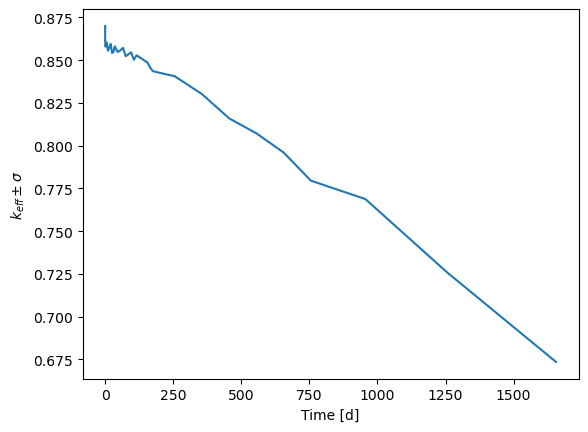

In [57]:
# Depletetion Post Processing

results = openmc.deplete.Results("./depletion_results.h5")
time, k = results.get_keff()
time /= (24 * 60 * 60)  # convert back to days from seconds
from matplotlib import pyplot
pyplot.plot(time, k[:, 0])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");
